In [1]:
import numpy as np
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import KFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE



In [ ]:
embedding = np.load('embeddingsFunctions.npy')

In [ ]:
embedding

In [ ]:
df_embeding = pd.DataFrame(embedding)

In [ ]:
df_embeding.head()

In [ ]:
# Check the platform
if os.name == 'nt':  # Windows
    file_path = "Big-Vul-dataset\data.json"
else:  # Unix/Linux/MacOS
    file_path = "Big-Vul-dataset/data.json"

# Load JSON data
with open(file_path, 'r') as file:
    df_bigVul = json.load(file)

# Convert JSON to DataFrame
df_bigVulPandas = pd.DataFrame(df_bigVul)

# Data Preprocessing

We concatinate the into single column in dataframe

In [ ]:
df_new = pd.DataFrame()
df_new['feature'] = df_embeding.apply(lambda row: row.values.tolist(), axis=1)

In [ ]:
df_new['vul'] = df_bigVulPandas['vul']

## Data exploration

In this part we will explore the data to understand the distribution of the target variable

In [ ]:
#Data exploration
df_new['vul'].value_counts()

In [ ]:
df_bigVulPandas

In [ ]:
vul_counts = df_bigVulPandas['vul'].value_counts()
print(vul_counts)

In [ ]:
df_bigVulPandas.shape

### Some helper functions

This part contains some helper functions that will be used in the following sections.

First function selects a random sample of non-vulnerable functions from the DataFrame is used to always select random data and prevent a bias in the model towards a favorable sample of the data.

The second one is specifically written for hyperparameter testing. It selects the first 8794 elements of the DataFrame, which is the same number of vulnerable functions in the dataset. We need this in order to make sure, that the sample does not introduce additional variance. This function is used to test the model's performance when the data is not randomly selected.

In [ ]:
def select_random_non_vulnerable(df, num_samples=8794):
    # Filter the DataFrame to only include non-vulnerable functions
    non_vulnerable = df[df['vul'] == 0]

    # Select a random sample of non-vulnerable functions
    random_sample = non_vulnerable.sample(n=num_samples, random_state=42)

    return random_sample

In [ ]:
def random_or_first(random=False, df_new=df_new, num_samples=8794):
    if random:
        # Select random non-vulnerable functions
        df_first = select_random_non_vulnerable(df_new, num_samples=num_samples)
    else:
        # Select the first 8794 elements
        df_first = df_new.iloc[:num_samples]

    return df_first

In [ ]:
# ROC curve function
def plot_roc_curve(classifier, X_test, y_test):
    # Get the predictions
    y_scores = classifier.predict_proba(list(X_test['feature']))

    # Compute ROC curve for the classifier
    fpr, tpr, thresholds = roc_curve(list(y_test), y_scores[:, 1])

    # Compute the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold value: {optimal_threshold}")

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Best Threshold = %0.2f' % optimal_threshold)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Select random or the first (for hyperparameter testing) non-vulnerable functions
df_first = random_or_first(random=True)

# Select the last 8794 elements
df_last = df_new.iloc[-8794:]

# Concatenate the first and last elements into the same DataFrame
df_combined = pd.concat([df_first, df_last])

In [ ]:
df_combined

## Train test splitting

In this part we will split the data into training and testing sets

With argument stratify=y we make sure that the train and test datasets have the same proportion of classes (0s and 1s) as the input dataset

In [ ]:
y = df_combined['vul']
X = df_combined.drop('vul', axis=1)

# stratify=y will make sure that the train and test datasets have the same proportion of classes (0s and 1s) as the input dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)#%%



## Training the models

In this part we will train the RandomForestModel and the XGBClassifier using the training data

### Random Forest Classifier

In this part we will train the RandomForestModel using the training data

In [ ]:
rf = RandomForestClassifier(max_depth=40, n_estimators=200, max_features='sqrt', random_state=42)
# Convert pandas Series of lists to numpy array
X_train_array = np.vstack(X_train['feature'])

# Now we can fit the RandomForestClassifier with the numpy arrays
rf.fit(X_train_array, y_train)

In [ ]:
X_test_array = np.vstack(X_test['feature'])
score=rf.score(X_test_array,y_test)
score

#### Evaluating the model

in this part we will evaluate the model using precision, recall and F1 score the test data

In [ ]:
# Get the predictions
predictions = rf.predict(list(X_test['feature']))

# Print the classification report
report = classification_report(list(y_test), predictions)
print(report)

#### ROC curve

In this part we will plot the ROC curve for the model

In [ ]:
# Get the predictions
y_scores = rf.predict_proba(list(X_test['feature']))

# Compute ROC curve for the classifier
fpr, tpr, thresholds = roc_curve(list(y_test), y_scores[:, 1])

# Compute the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold value: {optimal_threshold}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Best Threshold = %0.2f' % optimal_threshold)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### XG classifier

In this part we will train the XGBClassifier using the training data

In [ ]:
# Initialize XGBClassifier instance
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=200, max_depth=40, random_state=42)

# Fit XGBClassifier to the training data
xgb.fit(X_train_array, y_train)

#### Evaluating the model

in this part we will evaluate the model using precision, recall and F1 score the test data

In [ ]:
# Evaluataing the model

# Convert pandas Series of lists to numpy array for test data
X_test_array = np.vstack(X_test['feature'])

# Predict the labels for the test set
y_pred = xgb.predict(X_test_array)

# Print classification report
report = classification_report(y_test, y_pred)
print(report)

#### ROC curve

In this part we will plot the ROC curve for the model

In [ ]:
# Get the predictions
y_scores = xgb.predict_proba(list(X_test['feature']))

# Compute ROC curve for the classifier
fpr, tpr, thresholds = roc_curve(list(y_test), y_scores[:, 1])

# Compute the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold value: {optimal_threshold}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Best Threshold = %0.2f' % optimal_threshold)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### KNN Classifier

In [ ]:
#KNN Classifier
# Initialize XGBClassifier instance
knn = KNeighborsClassifier(n_neighbors=30)

# Fit XGBClassifier to the training data
knn.fit(X_train_array, y_train)

#### Evaluating the model

In [ ]:
# Predict the labels for the test set
y_pred = knn.predict(np.vstack(X_test['feature']))

# Print the classification report
print(classification_report(y_test, y_pred))

In [ ]:
# Get the predictions
y_scores = knn.predict_proba(list(X_test['feature']))

# Compute ROC curve for the classifier
fpr, tpr, thresholds = roc_curve(list(y_test), y_scores[:, 1])

# Compute the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold value: {optimal_threshold}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Best Threshold = %0.2f' % optimal_threshold)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plot_roc_curve(knn, X_test, y_test)

### Naiive Bayes Classifier

In [ ]:
#KNN Classifier
# Initialize XGBClassifier instance
gnb = GaussianNB()

# Fit XGBClassifier to the training data
gnb.fit(X_train_array, y_train)

In [ ]:
# Predict the labels for the test set
y_pred = gnb.predict(np.vstack(X_test['feature']))

# Print the classification report
print(classification_report(y_test, y_pred))

In [ ]:
plot_roc_curve(gnb, X_test, y_test)

## K-Fold Cross-validation

In this part we will perform k-fold cross-validation to evaluate the model and spot potential overfitting and underfitting and evaluate the model's performance based on different metrics

In [ ]:
# # Define dictionary with performance metrics
# scoring = {'accuracy': 'accuracy',
#            'precision': make_scorer(precision_score, average='weighted'),
#            'recall': make_scorer(recall_score, average='weighted'),
#            'f1_score': make_scorer(f1_score, average='weighted')}
# 
# X_array = np.vstack(X['feature'])
# y_array = np.array(y)
# 
# # Initialize scores dictionary
# scores = {metric: [] for metric in scoring.keys()}
# 
# # Compute metrics and append to scores dictionary
# fold_scores = cross_validate(rf, X_array, y_array, cv=5, scoring=scoring, verbose=1)
# 
# ### Calculate aggregated scores from cross-validation results ###
# 
# # Initialize an empty dictionary to store the aggregated values
# aggregated_scores = {}
# 
# # Iterate over each metric in the fold_scores dictionary
# for metric_name in fold_scores.keys():
#     # Skip non-score keys
#     if not metric_name.startswith('test_'):
#         continue
# 
#     # Calculate the mean and standard deviation of the metric
#     metric_mean = np.mean(fold_scores[metric_name])
#     metric_std = np.std(fold_scores[metric_name])
# 
#     # Store the aggregated values in the aggregated_scores dictionary
#     aggregated_scores[metric_name] = {
#         'mean': metric_mean,
#         'std': metric_std
#     }
# 
# # Print the aggregated_scores dictionary
# for metric, values in aggregated_scores.items():
#     print(f"{metric}: mean = {values['mean']}, std = {values['std']}")
# 


## Hyperparameter tuning

In this part we will use GridSearchCV to find the best hyperparameters for the RandomForestModel

*Uncomment to run -> 1 run with around 17500 samples lasts approx. 20Min on laptop CPU*

In [ ]:
# # Define the hyperparameters grid
# param_grid = {
#     'n_estimators': [10, 50, 100, 200],
#     'max_depth': [None, 10, 20, 30, 40, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }
# 
# # Initialize the GridSearchCV object
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
# 
# # Fit the GridSearchCV object to the data
# grid_search.fit(X, y)
# 
# # Get the best parameters and the best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_
# 
# print(f"Best parameters: {best_params}")
# print(f"Best score: {best_score}")

## Experimenting with oversampling with SMOTE

Since the Vulnerable functions are underrepresented in the dataset, we will experiment with oversampling using SMOTE to see if it improves the model's performance

In [ ]:
# select the first 17588 non vulnerable functions from df_new
df_first = random_or_first(random=False, num_samples=17588)

#combine the df_first and last 8794 elements
df_combined = pd.concat([df_first, df_last])

In [ ]:
df_combined

In [ ]:
# Initialize SMOTE instance
smote = SMOTE(random_state=42)

# Fit SMOTE and perform oversampling
df_oversampled = smote.fit_resample(df_combined['feature'].tolist(), df_combined['vul'].tolist())

In [ ]:
# Convert the output of SMOTE into a DataFrame
X_oversampled, y_oversampled = df_oversampled

# Create a DataFrame from these two lists
df_oversampled = pd.DataFrame(list(zip(X_oversampled, y_oversampled)), columns=['feature', 'vul'])

# Save the DataFrame to a CSV file
df_oversampled.to_csv('oversampled_data.csv', index=False)

In [2]:
df_oversampled = pd.read_csv('oversampled_data.csv')

In [11]:
def convert_str_to_np_array(df, column_name):
    df_list = []
    for i in tqdm(range(len(df)), desc="Processing"):
        np_array = np.fromstring(df.at[i, column_name].strip('[]'), dtype=float, sep=',')
        temp_df = pd.DataFrame([np_array])  # Convert Series to DataFrame
        df_list.append(temp_df)
    new_df = pd.concat(df_list, ignore_index=True)
    return new_df

In [12]:
# Convert the string representation of the list to a numpy array
df_oversampled_new = convert_str_to_np_array(df_oversampled, 'feature')

Processing: 100%|██████████| 35176/35176 [02:00<00:00, 292.69it/s]


In [13]:
df_oversampled_new

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-9.491208,-4.293011,6.557338,2.324635,-4.110653,-18.421602,3.545898,4.939705,13.935108,9.644430,...,14.129484,-6.404897,-8.465531,17.403751,-0.149862,10.612970,27.941216,-9.496958,-14.024918,18.459995
1,-50.307850,-5.665318,41.922859,5.622422,-46.825539,-45.153545,12.420534,27.428173,36.160347,51.240234,...,93.209892,-4.304795,-60.084942,80.325668,-42.661388,27.314810,90.997803,-102.127014,-67.217873,81.956268
2,-17.796965,-2.059369,14.956287,1.161129,-4.123035,-18.293316,8.428608,9.345697,17.435543,19.581253,...,21.622833,-11.094868,-22.534601,35.298897,-10.162546,11.461794,29.437634,-27.786087,-27.090714,32.711857
3,-15.114033,0.189284,13.828127,10.244881,-25.291935,-8.200372,-1.575973,11.206701,30.824116,18.168877,...,21.261433,-13.285295,-27.819294,30.270485,-17.241535,13.737978,44.297356,-18.110889,-19.301985,41.015862
4,-47.105614,-1.536545,41.922962,30.267897,-50.127007,-74.078018,8.260659,29.822273,54.405003,56.674427,...,73.100281,-16.279345,-63.755733,93.611946,-27.551670,39.698051,130.065796,-82.670166,-69.430428,99.613213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35171,-48.984464,-17.312131,32.567811,9.330974,-18.458956,-37.842599,9.918641,3.438531,55.511791,31.955561,...,83.601206,-19.855927,-66.171864,94.403868,-41.079724,29.279370,103.535935,-92.706340,-74.015133,87.599302
35172,-50.089782,-11.613571,31.562472,20.571160,-49.703332,-46.616434,11.714190,28.468938,41.194458,55.644162,...,81.195955,-10.208113,-65.172436,83.048656,-45.610672,35.693232,114.526583,-109.148493,-68.842741,86.018416
35173,-48.740327,7.768217,43.785631,31.122190,-21.775660,-52.860932,21.069912,27.917826,56.079516,44.348524,...,77.000212,-12.246682,-62.112088,83.773040,-23.404748,41.298755,108.042413,-76.605418,-69.661313,106.530517
35174,-56.233644,-6.113746,37.222893,13.737838,-74.864832,-49.735335,-1.796180,19.614555,51.426589,63.380287,...,87.491685,-16.208195,-73.028034,88.318108,-26.426341,48.084028,99.222485,-101.669221,-73.914257,89.209083


In [14]:
df_oversampled_new['vul'] = df_oversampled['vul']

In [22]:
df_oversampled['vul'].value_counts()

vul
0    17588
1    17588
Name: count, dtype: int64

In [15]:
#Splitting the df_oversampled into training and testing sets
y_over = df_oversampled_new['vul']
X_over = df_oversampled_new.drop('vul', axis=1)

# stratify=y will make sure that the train and test datasets have the same proportion of classes (0s and 1s) as the input dataset
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.2, random_state=42, stratify=y_over)



### Training the models with oversampled data

In this part we will train the RandomForestModel and the XGBClassifier using the oversampled training data

### XG classifier

In [17]:
# Initialize XGBClassifier instance
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=200, max_depth=40, random_state=42)

# # Convert pandas Series of lists to numpy array
# X_train_over_array = np.vstack(X_train_over['feature'])

# Fit XGBClassifier to the training data
xgb.fit(X_train_over, y_train_over)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=40,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
X_train_over_array = np.vstack(X_train_over['feature'])

In [ ]:
X_train_over_array

#### Evaluating the model

In [19]:
#Evaluate the model


# Predict the labels for the test set
y_pred = xgb.predict(X_test_over)

# Print classification report
report = classification_report(y_test_over, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.86      0.82      0.84      3518
           1       0.83      0.87      0.85      3518

    accuracy                           0.84      7036
   macro avg       0.84      0.84      0.84      7036
weighted avg       0.84      0.84      0.84      7036



#### ROC curve

Optimal threshold value: 0.6531768441200256


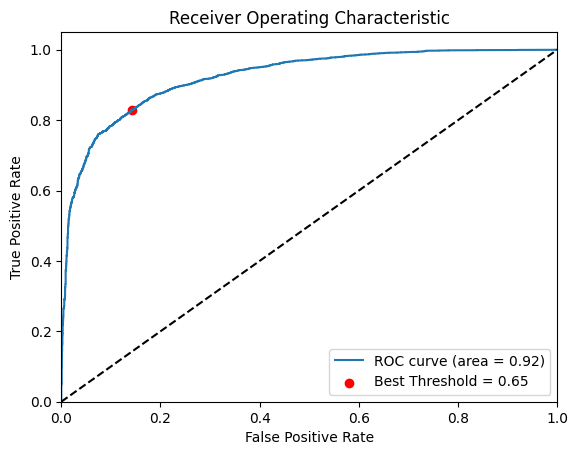

In [21]:
# Get the predictions
y_scores = xgb.predict_proba(X_test_over)

# Compute ROC curve for the classifier
fpr, tpr, thresholds = roc_curve(list(y_test_over), y_scores[:, 1])

# Compute the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold value: {optimal_threshold}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Best Threshold = %0.2f' % optimal_threshold)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Random Forest Classifier

In [24]:
# Initialize the RandomForestClassifier
rf_over = RandomForestClassifier(max_depth=40, n_estimators=200, max_features='sqrt', random_state=42)


# Now we can fit the RandomForestClassifier with the numpy arrays
rf_over.fit(X_train_over, y_train_over)

RandomForestClassifier(max_depth=40, n_estimators=200, random_state=42)

#### Evaluating the model

In [26]:
# Evaluate the model


# Predict the labels for the test set
y_pred = rf_over.predict(X_test_over)

# Print classification report
report = classification_report(y_test_over, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.83      0.78      0.80      3518
           1       0.79      0.84      0.82      3518

    accuracy                           0.81      7036
   macro avg       0.81      0.81      0.81      7036
weighted avg       0.81      0.81      0.81      7036



#### ROC curve

Optimal threshold value: 0.5148897110641297


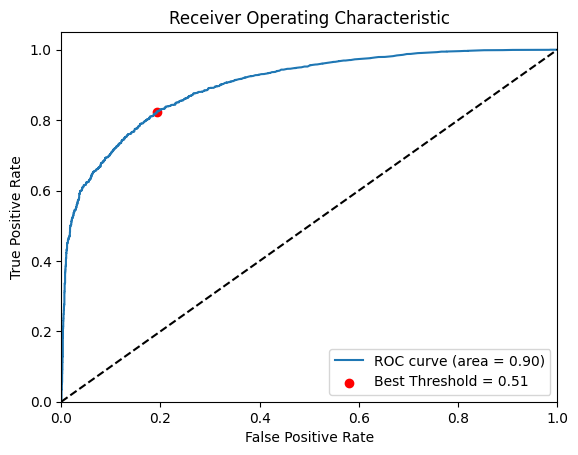

In [27]:
# Get the predictions
y_scores = rf_over.predict_proba(X_test_over)

# Compute ROC curve for the classifier
fpr, tpr, thresholds = roc_curve(y_test_over, y_scores[:, 1])

# Compute the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold value: {optimal_threshold}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Best Threshold = %0.2f' % optimal_threshold)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
